<a href="https://colab.research.google.com/github/who0liebo0lie/CTA_Evaluation/blob/main/Mortage_CTA_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** Mortage CTA Technical Assessment **

Project Description: A financial  website is a product comparision tool, calculator, and educational content for users seeking morgages. Maximizing revenue is achieved by having users scheduele an appointment for one of four mortage variations (each type has its own revenue).

A user clicks on a banner, fills out a form for type of mortage they want, and scheduele an appointment. Revenue is generated once the appointment is schedueled. A/B testing is being conducted which banner's CTA (call-to-action) and page placement combination appeals more to visitors to maximize a targeted metric.

Goal is to create a model to predict in real-time what CTA combination would be best to show to a future user.

**CTA versions:**

*   Pre-Aproved
*   First Time?
*   Access

**Page Placements **
(page intro=pi, page body=pb, page=p):


*   Top (image, pi,pb,p)
*   Middle (pi, image, pb, p)
*   Bottom (pi,pb,p, image)

**Data column explanations:**

* userId = Unique identifier for users visiting Financial Services

* sessionReferrer	= 	Source from which the user arrived (e.g., search engine)
browser	Browser used by the user (e.g., Chrome, Firefox)

* deviceType	= Category of device used by the user (e.g., mobile, desktop, tablet)

* estimatedAnnualIncome	= 	Estimated annual income of the user based on geographic location

* estimatedPropertyType	= 	Estimated property type (e.g., residential, commercial)

* visitCount	= Number of previous visits did the user have before the current visit

* pageURL	= 	URL of the current page visited

* ctaCopy	= 	Text of the call to action that was prompted to the user for potential engagement

* ctaPlacement	= 	Location of the call-to-action button on the page

* editorialSnippet	= Text surrounding the call-to-action

* scrollDepth	= 	Percentage of the page length scrolled by the user. If the user didn’t scroll on the page AFTER the ctaCopy and ctaPlacement already loaded, than scrollDepth will be 0.

* clickedCTA	= 	If the user clicked the call-to-action (yes 1/no 0)

* submittedForm	= 	If a user submitted the mortgage application form (yes 1/no 0)

* scheduledAppointment	= 	If the user scheduled an appointment regarding the mortgage application (yes 1/no 0)

* mortgageVariation	= 	Mortgage product variation the user applied for to discuss during the appointment. This only is present when someone scheduled an appointment

* revenue	= Revenue Financial Services received from the appointment scheduling and mortgage variation. If no scheduled appointment, this will be 0.


In [ ]:
#import libraries
#general
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

#visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
!pip install plotly
import plotly.express as px

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

#machine learning model requirements
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import (
    f1_score, roc_auc_score, accuracy_score,
    precision_recall_curve, roc_curve, average_precision_score, log_loss
)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

!pip install -U catboost

#models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [ ]:
#train = pd.read_csv("/train.csv")
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

test = pd.read_csv('/content/test.csv')
train= pd.read_csv('/content/train.csv')

Mounted at /content/drive


**EDA Exploration**

In [ ]:
def evaluate_file(file_path, duplicate_column=None):
    #Evaluates a given Excel file by printing general file information, checking for duplicate values in a specified column, searching for zero values, searching for empty (NaN) cells

    # Print file information
    print("\n=== File Info ===")
    print(file_path.info())

    # Check for duplicates in the specified column
    if duplicate_column:
        duplicate_count = file_path.duplicated(subset=[duplicate_column]).sum()
        print(f"\n=== Duplicates in '{duplicate_column}' ===")
        print(f"Total duplicate values: {duplicate_count}")

    # Check for zero values
    zero_values = (file_path == 0).sum().sum()
    print(f"\n=== Zero Values ===")
    print(f"Total zero values: {zero_values}")

    # Check for empty (NaN) cells
    missing_values = file_path.isnull().sum().sum()
    print(f"\n=== Empty (NaN) Cells ===")
    print(f"Total empty cells: {missing_values}")

    #print a sample
    display(file_path.sample(n=5))

In [ ]:
evaluate_file(test, duplicate_column="userId")


=== File Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   20000 non-null  object 
 1   userId                 20000 non-null  object 
 2   sessionReferrer        20000 non-null  object 
 3   browser                20000 non-null  object 
 4   deviceType             20000 non-null  object 
 5   estimatedAnnualIncome  16015 non-null  float64
 6   estimatedPropertyType  20000 non-null  object 
 7   visitCount             20000 non-null  int64  
 8   pageURL                20000 non-null  object 
 9   ctaCopy                20000 non-null  object 
 10  ctaPlacement           20000 non-null  object 
 11  editorialSnippet       20000 non-null  object 
 12  scrollDepth            20000 non-null  int64  
 13  submittedForm          20000 non-null  int64  
 14  scheduledAppointment   20000 non-nu

,date,userId,sessionReferrer,browser,deviceType,estimatedAnnualIncome,estimatedPropertyType,visitCount,pageURL,ctaCopy,ctaPlacement,editorialSnippet,scrollDepth,submittedForm,scheduledAppointment,mortgageVariation,revenue
10038,2024-09-30,user_173878,Social,Chrome,Mobile,72000.0,Apartment,1,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,Our tools help you assess whether refinancing ...,0,0,0.0,NaN,NaN
13713,2024-09-22,user_189762,Direct,Safari,Mobile,142000.0,House,1,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Top,Navigate the complexities of mortgage rates wi...,75,0,0.0,NaN,NaN
4784,2024-09-28,user_147766,Google,Chrome,Desktop,105000.0,Apartment,1,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Bottom,Unlock new financial opportunities by refinanc...,25,0,0.0,NaN,NaN
19609,2024-09-12,user_156516,Social,Safari,Desktop,235000.0,House,3,https://www.financialservices.com/mortgages/mo...,Access Your Personalized Mortgage Rates Now,Top,Our mortgage calculator is a powerful tool for...,100,1,1.0,C,275.0
9376,2024-09-13,user_148768,Google,Safari,Mobile,96000.0,Apartment,1,https://www.financialservices.com/mortgages/re...,Access Your Personalized Mortgage Rates Now,Bottom,Unlock new financial opportunities by refinanc...,50,0,0.0,NaN,NaN


Fix Issues in "Test" file

In [ ]:
#9k empty values for both revenue information and mortage variation are empty. explore why.
#check if an appointment was schedueled
# Filter rows where scheduledAppointment is True (or non-null/non-False)
scheduled = test[test["scheduledAppointment"] == True]
# Get value counts for the revenue column
revenue_counts = scheduled["revenue"].value_counts()
print(revenue_counts)

revenue
165.0    492
225.0    355
275.0    167
375.0     80
Name: count, dtype: int64


In [ ]:
#confirmed that the empty places in the revenue information was because an appointment was never schedueled. insert new letter "Z" to fill out for mortage variation and zero for appointment rather than na
# Build mask: revenue is missing AND scheduledAppointment is not True
mask = test["revenue"].isna() & (test["scheduledAppointment"] != True)

# Update mortgageVariation → "Z" where it's NaN
test.loc[mask & test["mortgageVariation"].isna(), "mortgageVariation"] = "Z"

# Update revenue → 0
test.loc[mask, "revenue"] = 0


In [ ]:
print(test.columns.tolist())

['date', 'userId', 'sessionReferrer', 'browser', 'deviceType', 'estimatedAnnualIncome', 'estimatedPropertyType', 'visitCount', 'pageURL', 'ctaCopy', 'ctaPlacement', 'editorialSnippet', 'scrollDepth', 'submittedForm', 'scheduledAppointment', 'mortgageVariation', 'revenue']


In [ ]:
#there is around 4k empty annual income. decide to due user segmentation and fill in mean for similiar (based on mortage variation and estimated property type).
#create new feature column of income missing flag where 1 = missing, 0 = not missing
test["Income_Missing"] = test["estimatedAnnualIncome"].isnull().astype(int)

#decide to use user segmentation and fill in mean for similiar (based on mortage variation and estimated property type).
# Remove stray spaces/tabs in column names (important!)
test.columns = test.columns.str.strip()

# Count missing values before filling
before_missing = test['estimatedAnnualIncome'].isna().sum()
print(f"Missing values before fill: {before_missing}")

# Apply median imputation by group
test['estimatedAnnualIncome'] = (
    test.groupby(['estimatedPropertyType', 'mortgageVariation'])['estimatedAnnualIncome']
        .transform(lambda x: x.fillna(x.median()))
)

# Count missing values after filling
after_missing = test['estimatedAnnualIncome'].isna().sum()
print(f"Missing values after fill: {after_missing}")

# How many were actually filled
print(f"Values filled: {before_missing - after_missing}")



Missing values before fill: 3985
Missing values after fill: 0
Values filled: 3985


In [ ]:
#confirm file ready
evaluate_file(test, duplicate_column="userId")


=== File Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   20000 non-null  object 
 1   userId                 20000 non-null  object 
 2   sessionReferrer        20000 non-null  object 
 3   browser                20000 non-null  object 
 4   deviceType             20000 non-null  object 
 5   estimatedAnnualIncome  20000 non-null  float64
 6   estimatedPropertyType  20000 non-null  object 
 7   visitCount             20000 non-null  int64  
 8   pageURL                20000 non-null  object 
 9   ctaCopy                20000 non-null  object 
 10  ctaPlacement           20000 non-null  object 
 11  editorialSnippet       20000 non-null  object 
 12  scrollDepth            20000 non-null  int64  
 13  submittedForm          20000 non-null  int64  
 14  scheduledAppointment   20000 non-nu

,date,userId,sessionReferrer,browser,deviceType,estimatedAnnualIncome,estimatedPropertyType,visitCount,pageURL,ctaCopy,ctaPlacement,editorialSnippet,scrollDepth,submittedForm,scheduledAppointment,mortgageVariation,revenue,Income_Missing
10741,2024-09-11,user_103302,Direct,Safari,Mobile,168000.0,House,1,https://www.financialservices.com/mortgages/ty...,Get Pre-Approved for a Mortgage in 5 Minutes,Bottom,Make an informed choice. Our detailed overview...,50,0,0.0,Z,0.0,0
14519,2024-09-18,user_199567,Google,Safari,Mobile,120000.0,Townhome,3,https://www.financialservices.com/mortgages/fi...,Access Your Personalized Mortgage Rates Now,Middle,"From budgeting to closing, we provide insights...",75,1,0.0,Z,0.0,0
15705,2024-09-09,user_174462,Google,Safari,Mobile,91000.0,House,1,https://www.financialservices.com/mortgages/ho...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,From improving your credit score to timing you...,100,0,0.0,Z,0.0,0
6208,2024-09-28,user_196347,Google,Safari,Desktop,120000.0,House,1,https://www.financialservices.com/mortgages/mo...,Get Pre-Approved for a Mortgage in 5 Minutes,Top,Our mortgage calculator is a powerful tool for...,25,0,0.0,Z,0.0,0
19419,2024-09-29,user_105764,Google,Safari,Mobile,130000.0,House,1,https://www.financialservices.com/mortgages/wh...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,We break down mortgage terminology and concept...,50,0,0.0,Z,0.0,1


Fix Issues in Train File

In [ ]:
evaluate_file(train, duplicate_column="userId")


=== File Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   100000 non-null  object 
 1   userId                 100000 non-null  object 
 2   sessionReferrer        100000 non-null  object 
 3   browser                100000 non-null  object 
 4   deviceType             100000 non-null  object 
 5   estimatedAnnualIncome  79986 non-null   float64
 6   estimatedPropertyType  100000 non-null  object 
 7   visitCount             100000 non-null  int64  
 8   pageURL                100000 non-null  object 
 9   ctaCopy                100000 non-null  object 
 10  ctaPlacement           100000 non-null  object 
 11  editorialSnippet       100000 non-null  object 
 12  scrollDepth            100000 non-null  int64  
 13  clickedCTA             100000 non-null  int64  
 14  submittedForm     

,date,userId,sessionReferrer,browser,deviceType,estimatedAnnualIncome,estimatedPropertyType,visitCount,pageURL,ctaCopy,ctaPlacement,editorialSnippet,scrollDepth,clickedCTA,submittedForm,scheduledAppointment,mortgageVariation,revenue
31626,9/10/24,user_93430,Direct,Safari,Desktop,NaN,House,4,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,Our comprehensive reviews offer insights into ...,75,0,0,0,NaN,NaN
89090,9/27/24,user_14641,Direct,Safari,Mobile,120000.0,House,2,https://www.financialservices.com/mortgages/be...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,"Compare rates, customer service, and loan opti...",75,1,1,0,NaN,NaN
3456,9/2/24,user_523,Google,Safari,Mobile,96000.0,House,1,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,Our comprehensive reviews offer insights into ...,75,0,0,0,NaN,NaN
14001,9/5/24,user_73993,Google,Firefox,Desktop,NaN,House,1,https://www.financialservices.com/mortgages/ho...,Get Pre-Approved for a Mortgage in 5 Minutes,Top,Learn strategies to secure the best mortgage r...,75,0,0,0,NaN,NaN
96237,9/29/24,user_17959,Google,Chrome,Mobile,177000.0,Townhome,1,https://www.financialservices.com/mortgages/mo...,Get Pre-Approved for a Mortgage in 5 Minutes,Bottom,Take control of your mortgage journey with our...,50,0,0,0,NaN,NaN


In [ ]:
#5517 empty values for both revenue information and mortage variation are empty. explore why.
#check if an appointment was schedueled
# Filter rows where scheduledAppointment is True (or non-null/non-False)
train_scheduled = train[train["scheduledAppointment"] == True]
# Get value counts for the revenue column
train_revenue_counts = train_scheduled["revenue"].value_counts()
print(train_revenue_counts)

revenue
165.0    2534
225.0    1590
275.0     952
375.0     441
Name: count, dtype: int64


In [ ]:
#confirmed that the empty places in the revenue information was because an appointment was never schedueled. insert new letter "Z" to fill out for mortage variation and zero for appointment rather than na
# Build mask: revenue is missing AND scheduledAppointment is not True
mask = train["revenue"].isna() & (train["scheduledAppointment"] != True)

# Update mortgageVariation → "Z" where it's NaN
train.loc[mask & train["mortgageVariation"].isna(), "mortgageVariation"] = "Z"

# Update revenue → 0
train.loc[mask, "revenue"] = 0


In [ ]:
#there is around 20 k empty annual income. decide to due user segmentation and fill in mean for similiar (based on mortage variation and estimated property type).
#create new feature column of income missing flag where 1 = missing, 0 = not missing
train["Income_Missing"] = train["estimatedAnnualIncome"].isnull().astype(int)

#decide to use user segmentation and fill in mean for similiar (based on mortage variation and estimated property type).
# Remove stray spaces/tabs in column names (important!)
train.columns = train.columns.str.strip()

# Count missing values before filling
before_missing = train['estimatedAnnualIncome'].isna().sum()
print(f"Missing values before fill: {before_missing}")

# Apply median imputation by group
train['estimatedAnnualIncome'] = (
    train.groupby(['estimatedPropertyType', 'mortgageVariation'])['estimatedAnnualIncome']
        .transform(lambda x: x.fillna(x.median()))
)

# Count missing values after filling
after_missing = train['estimatedAnnualIncome'].isna().sum()
print(f"Missing values after fill: {after_missing}")

# How many were actually filled
print(f"Values filled: {before_missing - after_missing}")


Missing values before fill: 20014
Missing values after fill: 0
Values filled: 20014


In [ ]:
train.head()

,date,userId,sessionReferrer,browser,deviceType,estimatedAnnualIncome,estimatedPropertyType,visitCount,pageURL,ctaCopy,ctaPlacement,editorialSnippet,scrollDepth,clickedCTA,submittedForm,scheduledAppointment,mortgageVariation,revenue,Income_Missing
0,9/1/24,user_97048,Google,Safari,Mobile,152000.0,Apartment,1,https://www.financialservices.com/mortgages/ty...,First Time? We've Made it Easy to Find the Bes...,Middle,"Understand the pros and cons of fixed-rate, ad...",75,0,0,0,Z,0.0,0
1,9/1/24,user_14393,Social,Safari,Mobile,140000.0,Apartment,2,https://www.financialservices.com/mortgages/ho...,Access Your Personalized Mortgage Rates Now,Bottom,Equip yourself with knowledge. Understand the ...,25,0,0,0,Z,0.0,0
2,9/1/24,user_30959,Direct,Safari,Mobile,128000.0,House,1,https://www.financialservices.com/mortgages/fi...,Access Your Personalized Mortgage Rates Now,Bottom,Navigate the home buying journey with confiden...,75,0,0,0,Z,0.0,0
3,9/1/24,user_88588,Google,Chrome,Mobile,205000.0,Apartment,1,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,Our tools help you assess whether refinancing ...,75,1,1,0,Z,0.0,0
4,9/1/24,user_65965,Google,Safari,Mobile,131000.0,House,1,https://www.financialservices.com/mortgages/re...,Access Your Personalized Mortgage Rates Now,Top,Navigate the complexities of mortgage rates wi...,0,0,0,0,Z,0.0,1


Visualizations of Trianing Data Overview

In [ ]:
#which ctaCopy and ctaPlacement resulted in most revenue?

#define pink palette
pink_palette = ["#FFC0CB", "#FFB6C1", "#FF69B4", "#FF1493", "#DB7093", "#C71585"]

#top CTA copy by total revenue
agg_copy = (
    train.groupby("ctaCopy", as_index=False)
      .agg(total_revenue=("revenue", "sum"),
           avg_revenue=("revenue", "mean"),
           n=("userId", "count"))
      .sort_values("total_revenue", ascending=False)
)

TOP_N = 50
agg_copy_top = agg_copy.head(TOP_N)

fig1 = px.bar(
    agg_copy_top,
    x="ctaCopy", y="total_revenue",
    hover_data={"avg_revenue":":.2f", "n": True, "ctaCopy": False},
    title=f"Top {min(TOP_N, len(agg_copy))} CTA Copy by Total Revenue",
    color="ctaCopy",
    color_discrete_sequence=pink_palette
)
fig1.update_layout(xaxis_title="CTA Copy", yaxis_title="Total Revenue", xaxis_tickangle=30)
fig1.show()

#tp placements by total revenue
agg_place = (
    train.groupby("ctaPlacement", as_index=False)
      .agg(total_revenue=("revenue", "sum"),
           avg_revenue=("revenue", "mean"),
           n=("userId", "count"))
      .sort_values("total_revenue", ascending=False)
)

fig2 = px.bar(
    agg_place,
    x="ctaPlacement", y="total_revenue",
    hover_data={"avg_revenue":":.2f", "n": True, "ctaPlacement": False},
    title="CTA Placement by Total Revenue",
    color="ctaPlacement",
    color_discrete_sequence=pink_palette
)
fig2.update_layout(xaxis_title="CTA Placement", yaxis_title="Total Revenue", xaxis_tickangle=0)
fig2.show()

#heatmap: revenue by CTA Copy and placement
pivot = train.pivot_table(
    values="revenue",
    index="ctaCopy",
    columns="ctaPlacement",
    aggfunc="sum",
    fill_value=0
)

top_copy_labels = pivot.sum(axis=1).sort_values(ascending=False).head(TOP_N).index.tolist()
pivot_top = pivot.loc[top_copy_labels]

fig3 = px.imshow(
    pivot_top,
    color_continuous_scale=["#FFE4E1", "#FFB6C1", "#FF69B4", "#FF1493"],  # pink gradient
    labels=dict(color="Total Revenue"),
    title=f"Revenue Heatmap: CTA Copy × Placement (Top {len(top_copy_labels)} CTA Copy)"
)
fig3.update_xaxes(title="CTA Placement")
fig3.update_yaxes(title="CTA Copy")
fig3.show()


In [ ]:
#average revenue from each type of property type

#group
agg = (
    train.groupby("estimatedPropertyType", as_index=False)
      .agg(total_revenue=("revenue", "sum"),
           avg_revenue=("revenue", "mean"),
           n=("userId", "count"))
      .sort_values("total_revenue", ascending=False)
)

pink_palette = ["#FFC0CB", "#FFB6C1", "#FF69B4", "#FF1493", "#DB7093", "#C71585"]

#total revenue by property type
fig_total = px.bar(
    agg, x="estimatedPropertyType", y="total_revenue",
    hover_data={"avg_revenue":":.2f", "n": True, "estimatedPropertyType": False},
    title="Total Revenue by Property Type",
    color="estimatedPropertyType",
    color_discrete_sequence=pink_palette
)
fig_total.update_layout(xaxis_title="Property Type", yaxis_title="Total Revenue", xaxis_tickangle=20)
fig_total.show()

#share of total revenue
fig_pie = px.pie(
    agg,
    names="estimatedPropertyType",
    values="total_revenue",
    title="Revenue Share by Property Type",
    color="estimatedPropertyType",
    color_discrete_sequence=pink_palette,
    # use custom_data so we can format nicely in hovertemplate
    custom_data=["avg_revenue", "n"]
)

fig_pie.update_traces(
    textposition="inside",
    textinfo="percent+label",
    hovertemplate=(
        "<b>%{label}</b><br>"
        "Total Revenue: %{value:,.0f}<br>"
        "Avg Revenue: %{customdata[0]:,.2f}<br>"
        "Count: %{customdata[1]}<extra></extra>"
    )
)
fig_pie.show()


In [ ]:
#did sessionReferrer, browser, or deviceType make a difference if appointment was booked.


pink_palette = ["#FF69B4"]  # solid hot pink for bars
pink_gradient = ["#FFE4E1", "#FFB6C1", "#FF69B4", "#FF1493"]

#utility to compute conversion & counts for any categorical column
def conversion_table(frame, cat_col):
    g = (frame
         .groupby(cat_col, dropna=False, as_index=False)
         .agg(total=("userId", "count"),
              booked=("scheduledAppointment", "sum")))
    g["conversion_rate"] = g["booked"] / g["total"]
    g[cat_col] = g[cat_col].fillna("Unknown")
    return g.sort_values("conversion_rate", ascending=False)

#conversion rate by each factor
for col in ["sessionReferrer", "browser", "deviceType"]:
    agg = conversion_table(train, col)
    fig = px.bar(
        agg, x=col, y="conversion_rate",
        hover_data={"total": True, "booked": True, "conversion_rate":":.2%"},
        title=f"Appointment Conversion Rate by {col}",
        text=agg["conversion_rate"].map(lambda v: f"{v:.1%}"),
        color=col,
        color_discrete_sequence=pink_palette
    )
    fig.update_layout(
        xaxis_title=col, yaxis_title="Conversion Rate", yaxis_tickformat=".0%",
        xaxis_tickangle=20, bargap=0.25
    )
    fig.show()

#two-way heatmaps of conversion
def conv_pivot(frame, row_col, col_col):
    piv = (frame
           .groupby([row_col, col_col], as_index=False)
           .agg(total=("userId","count"), booked=("scheduledAppointment","sum")))
    piv["conversion_rate"] = piv["booked"]/piv["total"]
    return piv.pivot(index=row_col, columns=col_col, values="conversion_rate").fillna(0)

heat = conv_pivot(train, "browser", "deviceType")

fig = px.imshow(
    heat,
    color_continuous_scale=pink_gradient,
    labels=dict(color="Conversion Rate"),
    title="Conversion Rate Heatmap: Browser × Device Type",
    text_auto=".0%"
)
fig.update_coloraxes(colorbar_tickformat=".0%")
fig.update_xaxes(title="Device Type")
fig.update_yaxes(title="Browser")
fig.show()



In [ ]:
train.columns

Index(['date', 'userId', 'sessionReferrer', 'browser', 'deviceType',
       'estimatedAnnualIncome', 'estimatedPropertyType', 'visitCount',
       'pageURL', 'ctaCopy', 'ctaPlacement', 'editorialSnippet', 'scrollDepth',
       'clickedCTA', 'submittedForm', 'scheduledAppointment',
       'mortgageVariation', 'revenue', 'Income_Missing'],
      dtype='object')

In [ ]:
train.head()

,date,userId,sessionReferrer,browser,deviceType,estimatedAnnualIncome,estimatedPropertyType,visitCount,pageURL,ctaCopy,ctaPlacement,editorialSnippet,scrollDepth,clickedCTA,submittedForm,scheduledAppointment,mortgageVariation,revenue,Income_Missing
0,9/1/24,user_97048,Google,Safari,Mobile,152000.0,Apartment,1,https://www.financialservices.com/mortgages/ty...,First Time? We've Made it Easy to Find the Bes...,Middle,"Understand the pros and cons of fixed-rate, ad...",75,0,0,0,Z,0.0,0
1,9/1/24,user_14393,Social,Safari,Mobile,140000.0,Apartment,2,https://www.financialservices.com/mortgages/ho...,Access Your Personalized Mortgage Rates Now,Bottom,Equip yourself with knowledge. Understand the ...,25,0,0,0,Z,0.0,0
2,9/1/24,user_30959,Direct,Safari,Mobile,128000.0,House,1,https://www.financialservices.com/mortgages/fi...,Access Your Personalized Mortgage Rates Now,Bottom,Navigate the home buying journey with confiden...,75,0,0,0,Z,0.0,0
3,9/1/24,user_88588,Google,Chrome,Mobile,205000.0,Apartment,1,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,Our tools help you assess whether refinancing ...,75,1,1,0,Z,0.0,0
4,9/1/24,user_65965,Google,Safari,Mobile,131000.0,House,1,https://www.financialservices.com/mortgages/re...,Access Your Personalized Mortgage Rates Now,Top,Navigate the complexities of mortgage rates wi...,0,0,0,0,Z,0.0,1


In [ ]:
#if the income was missing did revenue get generated?
import plotly.graph_objects as go
from plotly.subplots import make_subplots

train["rev_positive"] = (train["revenue"] > 0).astype(int)

agg = (train.groupby("Income_Missing", as_index=False)
            .agg(total_revenue=("revenue","sum"),
                 avg_revenue=("revenue","mean"),
                 n=("userId","count"),
                 any_revenue_rows=("rev_positive","sum")))

# compute percentage
agg["pct_with_revenue"] = agg["any_revenue_rows"] / agg["n"]

# Sort once for consistent ordering
agg_sorted_total = agg.sort_values("total_revenue", ascending=False)
agg_sorted_avg   = agg.sort_values("avg_revenue", ascending=False)

labels = agg_sorted_total["Income_Missing"].tolist()

pink_bar  = "#FF69B4"
pink_text = "#C71585"

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Total Revenue by Income Missing vs Present",
                    "Average Revenue by Income Missing vs Present")
)

#left subplot: Total Revenue
fig.add_trace(
    go.Bar(
        x=labels,
        y=agg_sorted_total["total_revenue"],
        text=[f"{v:,.0f}" for v in agg_sorted_total["total_revenue"]],
        textposition="outside",
        marker_color=pink_bar,
        hovertemplate=(
            "<b>%{x}</b><br>"
            "Total Revenue: %{y:,.0f}<br>"
            "Avg Revenue: %{customdata[0]:,.2f}<br>"
            "Count: %{customdata[1]}<br>"
            "Pct with Revenue: %{customdata[2]:.1%}<extra></extra>"
        ),
        customdata=np.stack([
            agg_sorted_total["avg_revenue"],
            agg_sorted_total["n"],
            agg_sorted_total["pct_with_revenue"]
        ], axis=-1)
    ),
    row=1, col=1
)

#right subplot: Average Revenue
fig.add_trace(
    go.Bar(
        x=agg_sorted_avg["Income_Missing"],
        y=agg_sorted_avg["avg_revenue"],
        text=[f"{v:,.2f}" for v in agg_sorted_avg["avg_revenue"]],
        textposition="outside",
        marker_color=pink_bar,
        hovertemplate=(
            "<b>%{x}</b><br>"
            "Avg Revenue: %{y:,.2f}<br>"
            "Total Revenue: %{customdata[0]:,.0f}<br>"
            "Count: %{customdata[1]}<br>"
            "Pct with Revenue: %{customdata[2]:.1%}<extra></extra>"
        ),
        customdata=np.stack([
            agg_sorted_avg["total_revenue"],
            agg_sorted_avg["n"],
            agg_sorted_avg["pct_with_revenue"]
        ], axis=-1)
    ),
    row=1, col=2
)

fig.update_layout(
    showlegend=False,
    bargap=0.25,
    margin=dict(t=80, r=30, l=40, b=60),
    title_font=dict(size=18),
)

fig.update_xaxes(title_text="", tickangle=20, row=1, col=1)
fig.update_yaxes(title_text="Total Revenue", row=1, col=1)

fig.update_xaxes(title_text="", tickangle=20, row=1, col=2)
fig.update_yaxes(title_text="Average Revenue", row=1, col=2)

fig.show()


In [ ]:
#most common type of mortage applied for

COL = "mortgageVariation"
counts = train[COL].value_counts(dropna=False).reset_index()
counts.columns = [COL, "count"]                # ✅ use strings
counts[COL] = counts[COL].fillna("Unknown")    # ✅ index by string column name

# pink shades palette
pink_palette = [
    "#FFC0CB", "#FFB6C1", "#FF69B4", "#FF1493", "#DB7093", "#C71585"
]

# pie chart
fig = px.pie(
    counts,
    names=COL,
    values="count",
    title="Distribution of Mortgage Variation Types",
    color=COL,
    color_discrete_sequence=pink_palette
)
fig.update_traces(textinfo="percent+label")
fig.show()

# 🔹 Exclude 'Z'
counts = counts[counts[COL].str.upper() != "Z"]

# Pie chart
fig2 = px.pie(
    counts,
    names=COL,
    values="count",
    title="Distribution of Mortgage Variation Types (excluding 'Z')",
    color=COL,
    color_discrete_sequence=pink_palette
)
fig2.update_traces(textinfo="percent+label")
fig2.show()


In [ ]:
pink_palette = ["#FFC0CB", "#FF69B4"]

# Relationship between scroll depth and visit count effect if appointment was booked
# Make sure scheduledAppointment is 0/1 first
def to01(x):
    if pd.isna(x): return 0
    if isinstance(x, (int, float)): return int(x != 0)
    s = str(x).strip().lower()
    return 1 if s in {"1","true","yes","y","booked"} else 0

train["scheduledAppointment"] = train["scheduledAppointment"].apply(to01).astype(int)

# Create Booked label column
train["Booked"] = train["scheduledAppointment"].map({0: "No", 1: "Yes"})

# Distributions by booking status - Scroll Depth
fig_box_scroll = px.box(
    train, x="Booked", y="scrollDepth",
    title="Scroll Depth Distribution by Booking Status",
    points="outliers",
    color="Booked",
    color_discrete_sequence=pink_palette
)
fig_box_scroll.update_layout(xaxis_title="Booked", yaxis_title="Scroll Depth (%)")
fig_box_scroll.show()

# Distributions by booking status - Visit Count
fig_box_visits = px.box(
    train, x="Booked", y="visitCount",
    title="Visit Count Distribution by Booking Status",
    points="outliers",
    color="Booked",
    color_discrete_sequence=pink_palette
)
fig_box_visits.update_layout(xaxis_title="Booked", yaxis_title="Visit Count")
fig_box_visits.show()

# Summary table
summary = (train.groupby("Booked", as_index=False)
           .agg(n=("userId","count"),
                avg_scroll=("scrollDepth","mean"),
                med_scroll=("scrollDepth","median"),
                avg_visits=("visitCount","mean"),
                med_visits=("visitCount","median")))

print(summary.to_string(index=False))


Booked     n  avg_scroll  med_scroll  avg_visits  med_visits
    No 94483   61.442535        75.0    2.217277         1.0
   Yes  5517   76.232554        75.0    2.372666         1.0


Lessons learned from visualizations:

There seems to be equal distribution between succes of the CTA placement and CTA copy when limited to the top 50.  Highest revenue was when the copy "First Time? We've Made it Easy to Find the Best Mortage Rate" was placed at the bottom of the page.   

People applying living at mobile homes were the least profitable type of housing using the website.  People applying who were already living in homes generated just under 600k of revenue. This accounts for almost half of the businesses.  

If people accessed the site directly it was most likely there would be revenue generated.  This indicates more marketing efforts should be directed towards people already living in homes to generate more revenue.  The type of browser only slightly made a difference in conversation rate.  Overall Firefox was highest but only by 1%. More likely that a customer would generate revenue if accessing on a desktop computer.

At first it appears that more revenue was generated if the income was present on the form.  However that has to do with the larger number of users who originally had income information listed.  On average the difference was only .34 difference between these types of users.

Users of the site 94% of the time do not generate revenue. The most common mortage type picked is type A.  However this is the cheapest type of mortage as far as revenue is concerned. The most expensive mortage type D is only selected 8% of the time for users who move forward in the process.

People who booked an appointment tended to scroll to see 100% of the page. This is a possible explanation on why having the CTA placement at the bottom was most successful.  The button was readily available once the user was finished scrolling. The visit count did not seem to effect revenue.  Users generally visited between 1-3 times.  This remained consistent across users who booked an appountment with an advisor and those who did not.

In [ ]:
#createCTA combination column
#9 different CTA combinations shown randomly

train('ctaPlacement')=train('')

,count
ctaPlacement,
Top,33334
Bottom,33333
Middle,33333


In [ ]:
#calculate performance metrics
cta_performance = train.groupby('cta_combination').agg({
    'revenue': ['count', 'sum', 'mean'],  # Total users, total revenue, revenue per user
    'clickedCTA': 'mean'  # Click-through rate
}).round(4)

print(cta_performance)

KeyError: 'cta_combination'

In [ ]:
#each CTA combination gets ~11% of traffic (100% ÷ 9 combinations)
#performance = weighted average of all combinations

Current_Performance = (Version1_Top × 11%) + (Version1_Middle × 11%) + ... + (Version3_Bottom × 11%)

In [ ]:
# Proposed: Give 100% of traffic the best-performing combination
# Performance = just the champion's performance

Champion_Performance = Best_CTA_Combination × 100%

In [ ]:
Incremental_Value_Per_User = Champion_Revenue_Per_User - Average_Revenue_Per_User

# Example numbers:
Champion_Revenue_Per_User = $0.75    # Best CTA performance
Average_Revenue_Per_User = $0.58     # Current A/B test average
Incremental_Value_Per_User = $0.17   # The "incremental" part

In [ ]:
Annual_Visitors = 100_000_000
Annual_Incremental_Value = Annual_Visitors × Incremental_Value_Per_User
Annual_Incremental_Value = 100M × $0.17 = $17M per year

Feature Engineering and Model Preperation

In [ ]:
#figure out income segmentation brackets by looking at range
COL = "estimatedAnnualIncome"

#income distribution from TRAIN data only
print(f"Income statistics (TRAIN):")
print(train[COL].describe())


#equal count quantile brackets based on TRAIN data
train['IncomeBracket'] = pd.qcut(train[COL],
                                q=5,
                                labels=['Low', 'Mid-Low', 'Middle', 'Mid-High', 'High'],
                                duplicates='drop')

print("\nQuantile brackets (≈ equal count) - TRAIN:")
print(train["IncomeBracket"].value_counts(dropna=False).to_string())

#cut points from the training data
cut_points = pd.qcut(train[COL].dropna(), q=5, duplicates='drop').cat.categories

#extract the boundary values
boundaries = []
for interval in cut_points:
    boundaries.append(interval.right)

#add minimum value as the first boundary
min_val = train[COL].min()
boundaries = [min_val] + boundaries
boundaries = sorted(list(set(boundaries)))

#apply SAME boundaries to test data using pd.cut
test['IncomeBracket'] = pd.cut(test[COL],
                              bins=boundaries,
                              labels=['Low', 'Mid-Low', 'Middle', 'Mid-High', 'High'],
                              include_lowest=True)

for bracket in train['IncomeBracket'].cat.categories:
    mask = train['IncomeBracket'] == bracket
    income_range = train.loc[mask, COL]
    print(f"{bracket}: ${income_range.min():,.0f} - ${income_range.max():,.0f}")


In [ ]:
#explicit combination feature
train["cta_combination"] = train["ctaCopy"].astype(str) + "_" + train["ctaPlacement"].astype(str)
test["cta_combination"]  = test["ctaCopy"].astype(str) + "_" + test["ctaPlacement"].astype(str)

In [ ]:
#drop columns which will not be needed any longer
train = train.drop(['date','userId','editorialSnippet','rev_positive','Booked'], axis=1)
test=test.drop(['date', 'userId','editorialSnippet'], axis=1)

In [ ]:
def encode_categoricals_and_booleans(df, drop_first=False):
    df = df.copy()

    #convert boolean columns to int
    bool_cols = df.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        df[col] = df[col].astype('int8')  # Memory efficient
        print(f"Converted boolean column '{col}' to numeric")

    #OHE categorical columns
    df_encoded = pd.get_dummies(df, drop_first=drop_first)

    # Ensure all dummy columns created by get_dummies are also int standardize to int8
    dummy_cols = [col for col in df_encoded.columns if col not in df.columns]
    for col in dummy_cols:
        if df_encoded[col].dtype in ['uint8', 'bool']:
            df_encoded[col] = df_encoded[col].astype('int8')

    if dummy_cols:
        print(f"Created {len(dummy_cols)} one-hot encoded columns (converted to int8)")

    return df_encoded

#generate
train = encode_categoricals_and_booleans(train, drop_first=False)
test = encode_categoricals_and_booleans(test, drop_first=False)

In [ ]:
#check that only have the same columns present in both test and tain
common = set(train.columns).intersection(test.columns)
only_in_train = set(train.columns) - set(test.columns)
only_in_test = set(test.columns) - set(train.columns)

print("Common columns:", common)
print("Only in train:", only_in_train)
print("Only in test:", only_in_test)

In [ ]:
#check for datatypes
train.info()
test.info()

Modeling

In [ ]:
#define featrures/target for training/test
features_train = train.drop(['clickedCTA'],axis=1)
target_train = train['clickedCTA']

In [ ]:
test['clickedCTA']=np.nan
features_test = test.drop(['clickedCTA'],axis=1)
target_test = train['clickedCTA']

In [ ]:
#initialize scaler
scaler = StandardScaler()

#fit and transform training data
features_train = scaler.fit_transform(features_train)

#transform test data
features_test = scaler.transform(features_test)

In [ ]:
# Define models and their respective parameter grids
models_and_params = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'random_state': [42]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'max_depth': [3, 5, 10],
            'random_state': [42]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 10],
            'random_state': [42]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),  # Increased max_iter for convergence
        'param_grid': {
            'C': [0.1, 1.0, 10.0],  # Added regularization parameters
            'random_state': [42]
        }
    },
    'XGBClassifier': {
        'model': xgb.XGBClassifier(eval_metric='logloss'),  # Use log loss for XGBoost
        'param_grid': {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.2],
            'max_depth': [3, 6],
            'random_state': [42]
        }
    },
    'LGBMClassifier': {
        'model': lgb.LGBMClassifier(objective='binary', metric='binary_logloss'),  # Use log loss for LGBM
        'param_grid': {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.2],
            'max_depth': [3, 6],
            'random_state': [42]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(loss_function='Logloss', verbose=False),  # Use log loss for CatBoost
        'param_grid': {
            'iterations': [100, 200],
            'learning_rate': [0.1, 0.2],
            'depth': [3, 6],
            'random_state': [42]
        }
    },
}

def train_models(models_and_params, features_train, target_train):
    #train models using GridSearchCV with log loss as primary scoring metric
    trained_models = {}

    for model_name, config in models_and_params.items():
        print(f"\nRunning GridSearchCV for {model_name}...")
        print(f"Parameter grid: {config['param_grid']}")

        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['param_grid'],
            cv=5,
            scoring='neg_log_loss',
            n_jobs=-1,
            verbose=1
        )

        try:
            grid_search.fit(features_train, target_train)

            #store best model
            best_model = grid_search.best_estimator_
            trained_models[model_name] = best_model

            print(f"Best {model_name} Parameters: {grid_search.best_params_}")
            print(f"Best CV Log Loss: {-grid_search.best_score_:.4f}")

        except Exception as e:
            print(f"Error training {model_name}: {str(e)}")
            continue

    return trained_models

def evaluate_models(trained_models, features_train, target_train, features_test, target_test):
    #evaluate all trained models with metrics including log loss
    print("\n" + "="*80)
    print("MODEL EVALUATION RESULTS")
    print("="*80)

    for model_name, model in trained_models.items():
        print(f"\n🔍 Evaluating {model_name}...")
        try:
            evaluate_classification_model(model_name, model, features_train, target_train, features_test, target_test)
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            continue

def safe_clip_probabilities(probabilities, epsilon=1e-15):
    #clip probabilities to avoid log(0) errors
    return np.clip(probabilities, epsilon, 1 - epsilon)

def evaluate_classification_model(model_name, model, features_train, target_train, features_test, target_test):
    #comprehensive model evaluation including log loss as primary metric
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    #each dataset evaluation separately
    datasets = [
        ('train', features_train, target_train),
        ('test', features_test, target_test)
    ]

    for dataset_type, features, target in datasets:
        eval_stats[dataset_type] = {}

        try:
            #predictions
            pred_target = model.predict(features)
            pred_proba = model.predict_proba(features)[:, 1]

            #avoid log loss errors
            pred_proba_clipped = safe_clip_probabilities(pred_proba)

            #all metrics
            eval_stats[dataset_type]['Log Loss'] = log_loss(target, pred_proba_clipped)
            eval_stats[dataset_type]['Accuracy'] = accuracy_score(target, pred_target)
            eval_stats[dataset_type]['F1'] = f1_score(target, pred_target)
            eval_stats[dataset_type]['ROC AUC'] = roc_auc_score(target, pred_proba)
            eval_stats[dataset_type]['APS'] = average_precision_score(target, pred_proba)

            #curves for plotting
            f1_thresholds = np.arange(0.01, 1.0, 0.05)  # Avoid 0 and 1 thresholds
            f1_scores = []
            for threshold in f1_thresholds:
                try:
                    f1 = f1_score(target, pred_proba >= threshold)
                    f1_scores.append(f1)
                except:
                    f1_scores.append(0)  # Handle edge cases

            fpr, tpr, _ = roc_curve(target, pred_proba)
            precision, recall, _ = precision_recall_curve(target, pred_proba)

            color = 'pink' if dataset_type == 'train' else 'purple'

            #F1 Score Plot
            ax = axs[0]
            ax.plot(f1_thresholds, f1_scores, color=color, label=f'{dataset_type}, max={max(f1_scores):.3f}')
            ax.set_xlabel('Threshold')
            ax.set_ylabel('F1 Score')
            ax.legend()
            ax.set_title(f'F1 Score vs Threshold ({model_name})')
            ax.grid(True, alpha=0.3)

            #ROC Curve
            ax = axs[1]
            ax.plot(fpr, tpr, color=color, label=f'{dataset_type}, AUC={roc_auc_score(target, pred_proba):.3f}')
            if dataset_type == 'train':  # Only plot diagonal once
                ax.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5)
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.legend()
            ax.set_title(f'ROC Curve ({model_name})')
            ax.grid(True, alpha=0.3)

            #Precision-Recall Curve
            ax = axs[2]
            ax.plot(recall, precision, color=color, label=f'{dataset_type}, AP={average_precision_score(target, pred_proba):.3f}')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.legend()
            ax.set_title(f'Precision-Recall Curve ({model_name})')
            ax.grid(True, alpha=0.3)

        except Exception as e:
            print(f"error processing {dataset_type} data for {model_name}: {str(e)}")
            continue

    #results table
    if eval_stats:
        df_eval_stats = pd.DataFrame(eval_stats).round(4)
        df_eval_stats = df_eval_stats.reindex(index=['Log Loss', 'Accuracy', 'F1', 'ROC AUC', 'APS'])

        print(f"\n📊 {model_name} Performance Metrics:")
        print(df_eval_stats)

        #flag if there's potential overfitting from log loss
        if 'train' in eval_stats and 'test' in eval_stats:
            train_log_loss = eval_stats['train']['Log Loss']
            test_log_loss = eval_stats['test']['Log Loss']
            log_loss_diff = test_log_loss - train_log_loss

            if log_loss_diff > 0.1:
                print(f"⚠️  Potential overfitting detected: Test log loss ({test_log_loss:.4f}) >> Train log loss ({train_log_loss:.4f})")
            elif log_loss_diff < 0.02:
                print(f"Good generalization: Similar train/test log loss")
            else:
                print(f"Acceptable generalization: Log loss difference = {log_loss_diff:.4f}")

        plt.tight_layout()
        plt.show()
    else:
        print(f"No evaluation results available for {model_name}")

def compare_model_performance(trained_models, features_test, target_test):
    #compare all models side-by-side
    print("\n" + "="*80)
    print("MODEL COMPARISON SUMMARY (Ranked by Test Log Loss)")
    print("="*80)

    comparison_results = {}

    for model_name, model in trained_models.items():
        pred_proba = safe_clip_probabilities(model.predict_proba(features_test)[:, 1])
        pred_binary = model.predict(features_test)

        comparison_results[model_name] = {
            'Log Loss': log_loss(target_test, pred_proba),
            'ROC AUC': roc_auc_score(target_test, pred_proba),
            'F1 Score': f1_score(target_test, pred_binary),
            'Accuracy': accuracy_score(target_test, pred_binary),
            'Avg Precision': average_precision_score(target_test, pred_proba)
        }

    #create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_results).T.round(4)

    #sort by log loss
    comparison_df = comparison_df.sort_values('Log Loss', ascending=True)

    print(comparison_df)

    #identify best model
    best_model_name = comparison_df.index[0]
    best_log_loss = comparison_df.loc[best_model_name, 'Log Loss']

    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   Log Loss: {best_log_loss:.4f}")
    print(f"   ROC AUC: {comparison_df.loc[best_model_name, 'ROC AUC']:.4f}")
    print(f"   F1 Score: {comparison_df.loc[best_model_name, 'F1 Score']:.4f}")

    return comparison_df

def run_complete_pipeline(models_and_params, features_train, target_train, features_test, target_test):
    #complete training and evaluation pipeline with log loss focus
    print("🚀 Starting Model Training Pipeline with Log Loss Optimization")
    print(f"Training set shape: {features_train.shape}")
    print(f"Test set shape: {features_test.shape}")
    print(f"Class distribution: {np.bincount(target_train)}")

    #train models
    trained_models = train_models(models_and_params, features_train, target_train)

    if not trained_models:
        print("❌ No models were successfully trained!")
        return None, None

    #evaluate models
    evaluate_models(trained_models, features_train, target_train, features_test, target_test)

    #compare models
    comparison_results = compare_model_performance(trained_models, features_test, target_test)

    return trained_models, comparison_results


In [ ]:
trained_models = train_models(models_and_params, features_train, target_train)
evaluate_models(trained_models, features_train, target_train, features_test, target_test)
comparison = compare_model_performance(trained_models, features_test, target_test)


Running GridSearchCV for RandomForest...
Best RandomForest Parameters: {'max_depth': 10, 'n_estimators': 50, 'random_state': 42}

Running GridSearchCV for DecisionTree...
Best DecisionTree Parameters: {'max_depth': 3, 'random_state': 42}

Running GridSearchCV for GradientBoosting...
Best GradientBoosting Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'random_state': 42}

Running GridSearchCV for LogisticRegression...
Best LogisticRegression Parameters: {}

Running GridSearchCV for XGBClassifier...
Best XGBClassifier Parameters: {}

Running GridSearchCV for LGBMClassifier...
[LightGBM] [Info] Number of positive: 17261, number of negative: 82739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 100000

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Learning rate set to 0.07361
0:	learn: 0.5592413	total: 71.5ms	remaining: 1m 11s
1:	learn: 0.4565322	total: 91.6ms	remaining: 45.7s
2:	learn: 0.3779166	total: 113ms	remaining: 37.4s
3:	learn: 0.3201868	total: 135ms	remaining: 33.6s
4:	learn: 0.2757813	total: 155ms	remaining: 30.9s
5:	learn: 0.2405903	total: 182ms	remaining: 30.1s
6:	learn: 0.2146224	total: 205ms	remaining: 29s
7:	learn: 0.1905723	total: 225ms	remaining: 27.9s
8:	learn: 0.1749334	total: 248ms	remaining: 27.4s
9:	learn: 0.1628159	total: 269ms	remaining: 26.6s
10:	learn: 0.1528373	total: 292ms	remaining: 26.2s
11:	learn: 0.1448986	total: 317ms	remaining: 26.1s
12:	learn: 0.1367757	total: 341ms	remaining: 25.9s
13:	learn: 0.1311914	total: 362ms	remaining: 25.5s
14:	learn: 0.1270214	total: 392ms	remaining: 25.8s
15:	learn: 0.1236374	total: 421ms	remaining: 25.9s
16:	learn: 0.1205621	total: 447ms	remaining: 25.9s
17:	learn: 0.1178034	total: 474ms	remaining: 25.9s
18:	learn: 0.1143120	total: 497ms	remaining: 25.7s
19:	learn: 

ValueError: Found input variables with inconsistent numbers of samples: [100000, 20000]

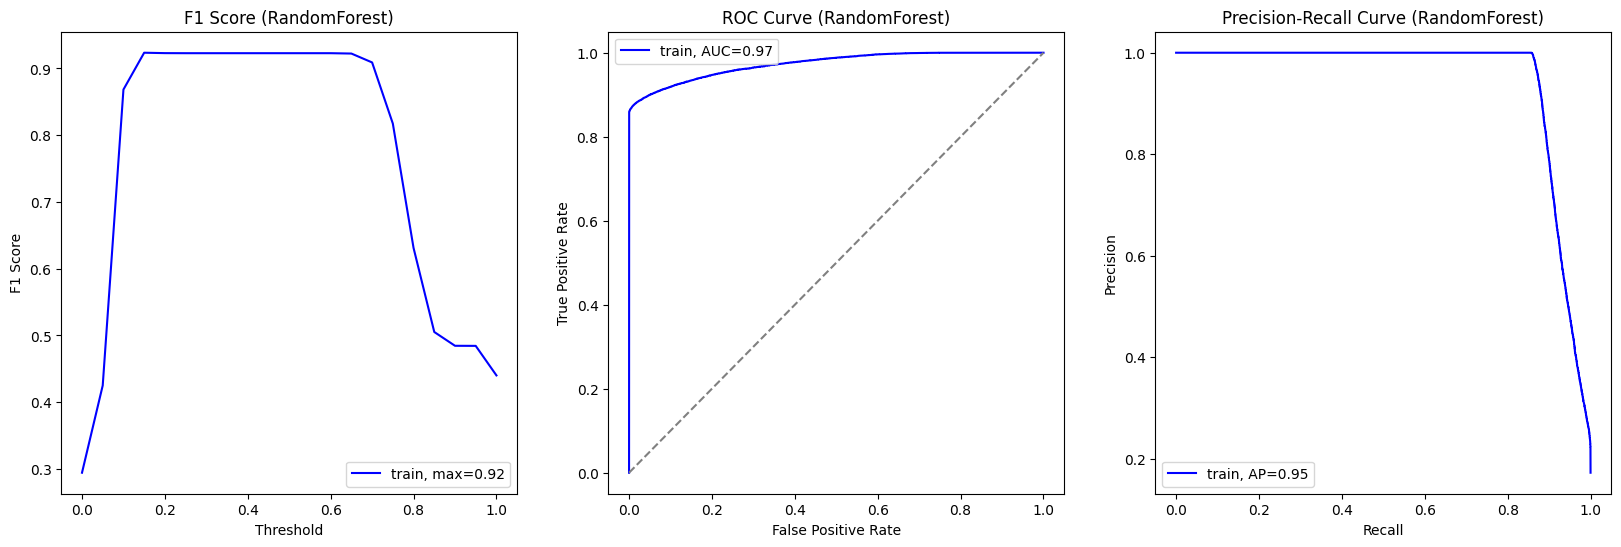

In [ ]:
#define models and their respective parameter grids
models_and_params = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'random_state': [42]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'max_depth': [3, 5, 10],
            'random_state': [42]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 10],
            'random_state': [42]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'param_grid': {}
    },
    'XGBClassifier': {
        'model': xgb.XGBClassifier(),
        'param_grid': {}
    },
    'LGBMClassifier': {
        'model': lgb.LGBMClassifier(),
        'param_grid': {}
    },
    'CatBoost': {
        'model': CatBoostClassifier(),
        'param_grid': {}
    },
}

def train_models(models_and_params, features_train, target_train):
    trained_models = {}

    for model_name, config in models_and_params.items():
        print(f"\nRunning GridSearchCV for {model_name}...")

        # Hyperparameter tuning
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['param_grid'],
            cv=5,
            scoring='f1',
            n_jobs=-1
        )
        grid_search.fit(features_train, target_train)

        # Store the best model
        best_model = grid_search.best_estimator_
        trained_models[model_name] = best_model
        print(f"Best {model_name} Parameters: {grid_search.best_params_}")

    return trained_models

def evaluate_models(trained_models, features_train, target_train, features_test, target_test):
    for model_name, model in trained_models.items():
        print(f"\nEvaluating {model_name}...")
        evaluate_classification_model(model_name, model, features_train, target_train, features_test, target_test)

def evaluate_classification_model(model_name, model, features_train, target_train, features_test, target_test):
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for dataset_type, features, target in [('train', features_train, target_train), ('test', features_test, target_test)]:
        eval_stats[dataset_type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]  # Use the correct dataset

        # Compute metrics
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]
        fpr, tpr, _ = roc_curve(target, pred_proba)
        precision, recall, _ = precision_recall_curve(target, pred_proba)

        # Aggregate results
        eval_stats[dataset_type]['Accuracy'] = accuracy_score(target, pred_target)
        eval_stats[dataset_type]['F1'] = f1_score(target, pred_target)
        eval_stats[dataset_type]['ROC AUC'] = roc_auc_score(target, pred_proba)
        eval_stats[dataset_type]['APS'] = average_precision_score(target, pred_proba)

        color = 'blue' if dataset_type == 'train' else 'green'

        # F1 Score Plot
        ax = axs[0]
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{dataset_type}, max={max(f1_scores):.2f}')
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1 Score')
        ax.legend()
        ax.set_title(f'F1 Score ({model_name})')

        # ROC Curve
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{dataset_type}, AUC={roc_auc_score(target, pred_proba):.2f}')
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend()
        ax.set_title(f'ROC Curve ({model_name})')

        # Precision-Recall Curve
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{dataset_type}, AP={average_precision_score(target, pred_proba):.2f}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()
        ax.set_title(f'Precision-Recall Curve ({model_name})')

    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=['Accuracy', 'F1', 'APS', 'ROC AUC'])

    print(df_eval_stats)
    plt.show()

#run training and evaluation separately
trained_models = train_models(models_and_params, features_train, target_train)
evaluate_models(trained_models, features_train, target_train, features_test, target_test)

In [ ]:
def find_best_model_by_auc(trained_models, features_test, target_test):
    """Find the model with the highest ROC-AUC score on the test set."""
    best_model = None
    best_model_name = None
    best_auc = 0

    for model_name, model in trained_models.items():
        pred_proba = model.predict_proba(features_test)[:, 1]
        auc = roc_auc_score(target_test, pred_proba)

        print(f"{model_name} Test ROC-AUC: {auc:.4f}")

        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_model_name = model_name

    print(f"\nBest Model: {best_model_name} with ROC-AUC: {best_auc:.4f}")
    return best_model, best_model_name

# Find the best model based on ROC-AUC
best_model, best_model_name = find_best_model_by_auc(trained_models, features_test, target_test)

# Compute ROC-AUC on the validation set using the best model
best_val_pred_proba = best_model.predict_proba(features_valid)[:, 1]
auc_roc_val = roc_auc_score(target_valid, best_val_pred_proba)

print(f"AUC-ROC Score for Best Model ({best_model_name}) on Validation Set: {auc_roc_val:.4f}")

In [ ]:
# ✅ INCLUDE these columns:
features_to_include = [
    'estimatedAnnualIncome', 'visitCount', 'scrollDepth',
    'ctaCopy_*', 'ctaPlacement_*',  # CTA experiment features
    'deviceType_*', 'browser_*',    # Tech context
    'sessionReferrer_*',            # Traffic source
    # ... other pre-click features
]

#exclude columns since happens after clicking and avoid causing data leakage:
exclude_columns = [
    'submittedForm',
    'scheduledAppointment',
    'revenue',
    'mortgageVariation_*'
]

In [ ]:
# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Get probabilities (not just predictions)
probabilities = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Evaluate with log loss
validation_loss = log_loss(y_val, val_probabilities)
print(f"Log Loss: {validation_loss:.4f}")  # Lower is better

In [ ]:
# Create submission file
submission = pd.DataFrame({
    'userId': test_user_ids,
    'pr_CTA': probabilities
})
submission.to_csv('JuliaPorrino_predictions.csv', index=False)

In evluating CTA combinations some metrics are provided are the clickedCTA, submittedForm, scheueledAppointment, and revenue. This provides information for first and second conversion points.

CTA copy read “First Time? We’ve Made it Easy to Find the Best Mortgage Rate” with a placement at the bottom of the page.  Coming in next of highest conversion point was the copy “Get Pre-Approved for a Mortgage in 5 minutes” at the top of the page.  The least successful is the copy “Access Your Personalized Mortgage Rates Now” at the bottom of the page.

Users who are already home owners tend to be more corelated with clicking the CTA copy.  People were more likely to create an appointment on a desktop device. Most popular browser is Firefox. Least successful conversion users used Safari. Most successful session referrer is direct or email (both above 7%). Least successful conversion was through social session referrer. Mobile Firefox users were least likely to make conversion. Most revenue is generated by people who already have a house.  Least likely to generate revenue is users who live in a mobile home. 94% of users did not make an appointment or select a mortgage variation.  Beyond that the most common mortgage variation was type A which generated the least revenue per user ($165). People who booked an appointment scrolled on average between 80-100% of the page.  


What ways can you manipulate the columns/dataset to create features that increase predictive power towards our key metric?
Feature creation of income segmentation designation and CTA combinations (copy&position) increases the predictive power for ‘clickedCTA’. Manipulation of data also is required to perform one-hot-encoding on categorical columns.  All boolean values also are transitioned to 0/1 response rather than True/False. The data will also be scaled so that more weight is not given to specific columns.


Besides Log Loss, what other metrics will you use to evaluate the model's performance, and why?
Metrics used to evaluate model performances are F1, accuracy, ROC AUC, and average precision score.  Accuracy evaluates the general performance. F1 considers both false positives and negatives to combine precision and recall into one metric.  ROC-AUC evaluates how well the model separates classes across all threesholds. Average precision score focuses on positive class performance.

What additional predictive model would you build to inform which CTA combinations would maximize the revenue in addition to predict ClickedCTA, and why?
It would be interesting to build predictive models separated by CTA combinations.  There would then be 9 models trained to predict accurately for each subtype.  

If we called one of these CTA combinations our champion (serve it 100% of the time), how much incrementally is that worth to us vs. the average of the rest of the split test?

The CTA combination of copy read “First Time? We’ve Made it Easy to Find the Best Mortgage Rate” with a placement at the bottom of the page has been the most successful to be served 100% of the time. Incrementally it is worth vs. the average of the rest of the split test.  
